In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI

from tqdm import tqdm

imagespath = 'error_gradation_images'

In [2]:
data = pd.read_csv("../../../datasets/abalone.data", sep=',', names=['sex', 'length', 'diameter', 'height', 'W_weight', 'S_weight', 'viscera_weight', 'shell_weight', 'rings'])
data.drop(columns=["sex"], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
target = "rings"
features = data.columns.difference([target]).tolist()

data.head(10)

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [3]:
#sns.pairplot(data=data)

In [4]:
def entropy(a):
    vc = a.value_counts()
    vc/=vc.sum()
    return -(vc*np.log(vc)).sum()

In [5]:
def discretize(data, variables, icat, icont, contdiscstrategy="kmeans", n_bins=3):
    transformers_data = dict()
    
    if icat is None: # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy), 
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None: # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"), 
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
        make_pipeline(FunctionTransformer(lambda x: x.iloc[:, icat]), OrdinalEncoder(categories="auto")),
        make_pipeline(FunctionTransformer(lambda x: x.loc[:, icont]), KBinsDiscretizer(n_bins=n_bins, encode="ordinal", random_state=42, strategy=contdiscstrategy))
    ),
        FunctionTransformer(lambda x: x.astype("int")))
    
    
    pipeline.fit(data)
    encoded_data = pd.DataFrame(pipeline.transform(data), columns=data.columns if icat is None or icont is None\
                                                                                        else data.columns[icat+icont])
    encoded_data = encoded_data[variables] # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь

    for feat in encoded_data.columns:
        if entropy(encoded_data[feat]) < 0.5:
            print(f"Warning: feature {feat} has practically degenerate states and low entropy")
    transformers_data["transformer"] = pipeline
    
    if icat is None:
        transformers_data["cont_features"]       = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_
        
    elif icont is None:
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_
        
    else:
        transformers_data["cont_features"]           = list(pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"]     = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].bin_edges_
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_
    
    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

#disc_data, pipeline_data = discretize(data, variables, icat=None, icont=[0, 1])


In [6]:
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [7]:
for i in range(3):
    print(data[data_disc["height"]==i]["height"].min(), data[data_disc["height"]==i]["height"].max())
tfdata["cont_features_edges"][2]

0.0 0.25
0.515 0.515
1.13 1.13


array([0.        , 0.32709461, 0.8225    , 1.13      ])

In [8]:
tfdata["cont_features"]

['length',
 'diameter',
 'height',
 'W_weight',
 'S_weight',
 'viscera_weight',
 'shell_weight',
 'rings']

In [9]:
data = data[data["height"]<0.26]
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [10]:
for feat in [data_disc.columns[3]]:
    print(feat)
    print(data_disc[feat].value_counts(), data[feat].max())

height
height
1    1883
2    1404
0     888
Name: count, dtype: int64 0.25


In [11]:
#model = GradientBoostingRegressor(n_estimators=30,)
model = LinearRegression()
model.fit(data[features], data[target])

LinearRegression()

In [12]:
#model.coef_, model.intercept_

In [13]:
data_errors = data.copy(deep=True)
data_errors["ape_error"] = np.abs((data[target]-model.predict(data[features]))/data[target])
data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,length,diameter,height,W_weight,S_weight,viscera_weight,shell_weight,ape_error
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.435809
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.034495
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.199540
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.065088
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.012058


In [14]:
disc_data, pipeline_data = discretize(data_errors, features+["ape_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,S_weight,W_weight,diameter,height,length,shell_weight,viscera_weight,ape_error
0,0,0,1,0,1,0,0,1
1,0,0,0,0,0,0,0,0
2,0,1,1,1,1,1,0,0
3,0,0,1,1,1,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4170,1,1,2,2,2,1,1,0
4171,1,1,2,1,2,1,1,0
4172,1,1,2,2,2,1,2,1
4173,1,1,2,1,2,1,1,0


In [15]:
disc_data.columns

Index(['S_weight', 'W_weight', 'diameter', 'height', 'length', 'shell_weight',
       'viscera_weight', 'ape_error'],
      dtype='object')

In [16]:
disc_data["ape_error"].value_counts()

ape_error
0    2951
1    1219
2       5
Name: count, dtype: int64

In [17]:
pipeline_data["transformer"].steps[0][1].bin_edges_

array([array([0.075     , 0.40781788, 0.55885327, 0.815     ]),
       array([0.055     , 0.30950751, 0.43446298, 0.65      ]),
       array([0.        , 0.10939743, 0.15740856, 0.25      ]),
       array([2.00000000e-03, 6.71022908e-01, 1.29029846e+00, 2.82550000e+00]),
       array([1.00000000e-03, 2.88607762e-01, 5.65832034e-01, 1.48800000e+00]),
       array([5.00000000e-04, 1.41643439e-01, 2.78531845e-01, 7.60000000e-01]),
       array([0.0015    , 0.1965031 , 0.37574715, 1.005     ]),
       array([6.54790386e-05, 2.07273470e-01, 9.17948437e-01, 2.38444282e+00])],
      dtype=object)

In [18]:
v = pipeline_data["cont_features_edges"]
v[7] = [v[7][0], (v[7][0]+v[7][1])/2, v[7][1], v[7][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [19]:
data__ = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=disc_data.columns)
data__

,S_weight,W_weight,diameter,height,length,shell_weight,viscera_weight,ape_error
0,1,1,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,1
3,1,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
4170,2,2,2,1,1,1,1,0
4171,2,2,1,1,1,1,1,0
4172,2,2,2,1,1,2,1,2
4173,2,2,1,1,1,1,1,0


In [20]:
data__["ape_error"].value_counts()

ape_error
0    1702
1    1249
2    1224
Name: count, dtype: int64

In [21]:
entropy(data__["ape_error"])

1.0865425843287362

In [22]:
disc_data = data__

In [23]:
current_error = data_errors["ape_error"].sum()/n
current_error

0.16148628474926513

In [24]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [25]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'length': 3,
 'diameter': 3,
 'height': 3,
 'W_weight': 3,
 'S_weight': 3,
 'viscera_weight': 3,
 'shell_weight': 3,
 'ape_error': 3}

In [34]:

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("ape_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [35]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [36]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,length,Discrete,disc,[],[]
1,ape_error,Discrete,disc,[],[]
2,height,Discrete,disc,[length],[disc]
3,S_weight,Discrete,disc,"[height, length]","[disc, disc]"
4,W_weight,Discrete,disc,"[S_weight, height]","[disc, disc]"
5,shell_weight,Discrete,disc,"[S_weight, height]","[disc, disc]"
6,viscera_weight,Discrete,disc,"[W_weight, height]","[disc, disc]"
7,diameter,Discrete,disc,"[W_weight, viscera_weight]","[disc, disc]"


In [29]:
from bamt.nodes.discrete_node import DiscreteNode

In [30]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [31]:
bn.distributions

{'viscera_weight': {'cprob': [0.42107784431137724,
   0.4244311377245509,
   0.15449101796407186],
  'vals': ['0', '1', '2']},
 'ape_error': {'cprob': [0.4076646706586826,
   0.29916167664670656,
   0.29317365269461076],
  'vals': ['0', '1', '2']},
 'W_weight': {'cprob': {"['0']": [0.3987485779294653,
    0.590443686006826,
    0.01080773606370876],
   "['1']": [0.001128668171557562, 0.2652370203160271, 0.7336343115124153],
   "['2']": [0.0, 0.018604651162790697, 0.9813953488372092]},
  'vals': ['0', '1', '2']},
 'height': {'cprob': {"['1', '0']": [0.9046242774566474,
    0.0953757225433526,
    0.0],
   "['1', '1']": [0.2, 0.7978723404255319, 0.002127659574468085],
   "['1', '2']": [0.0, 0.4166666666666667, 0.5833333333333334],
   "['0', '0']": [1.0, 0.0, 0.0],
   "['0', '1']": [1.0, 0.0, 0.0],
   "['0', '2']": [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
   "['2', '0']": [0.10526315789473684,
    0.7368421052631579,
    0.15789473684210525],
   "['2', '1']": [0.00230

In [32]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

In [33]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 0}, nbars=10)

ValueError: Node not present in the Directed Graph

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 1}, nbars=10)

In [ ]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии среднего веса панциря

In [ ]:
current_error

In [39]:
from copy import copy

In [40]:
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as mape

### Пробуем отсеивать долю наблюдений с высокой ошибкой

In [ ]:
data_errors.shape, data.shape

In [ ]:
data_errors

In [41]:
#dfeat = ["shell_weight", "height"]
#dcat = [1, 0]
#dfeat = ["height"]
dcat = [0, 0]
dfeat = ["length", "viscera_weight"]
#dcat = [1]
# = data[disc_data[dfeat]==1][dfeat].min(), data[disc_data[dfeat]==1][dfeat].max()
bn = n
def bootstrap_sampling(dfeat, dcat, metrics_list, trials=1000, alpha=0, incl_random_removal=False):
    
    diffs = list()
    metrics_before, metrics_after = [list() for _ in range(len(metrics_list))], [list() for _ in range(len(metrics_list))]
    metrics_random = [list() for _ in range(len(metrics_list))]
    n_dropped = list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        indexes = np.random.choice(data.index, size=bn)
        bsample = data.loc[indexes]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(data_errors.loc[indexes]), columns=data_errors.columns)
        
        mask = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
        
        X1, y1 = bsample[features], bsample[target]
        model1, model2 = copy(model), copy(model)
        model1.fit(X1, y1)
        y1_pred = model1.predict(X1)
        indexes_to_drop = np.random.choice(bsample[mask].index, size=int(np.floor(bsample[mask].shape[0]*(1-alpha))), replace=False)
        
        new_bsample = bsample.drop(index=indexes_to_drop)
        
        
        X2, y2 = new_bsample[features], new_bsample[target]
        
        model2.fit(X2, y2)
        
        y2_pred = model2.predict(X2)
        for k, metric in enumerate(metrics_list):
            metrics_before[k].append(metric(y1, y1_pred))
            metrics_after[k].append(metric(y2, y2_pred))
        
        if incl_random_removal:
            random_bsample = bsample.sample(indexes_to_drop.shape[0])
            X3, y3 = random_bsample[features], random_bsample[target]
            model3 = copy(model)
            model3.fit(X3, y3)
            y3_pred = model3.predict(X3)
            for k, metric in enumerate(metrics_list):
                metrics_random[k].append(metric(y3, y3_pred))
            
            
        diffs.append(metrics_before[0][-1] - metrics_after[0][-1])
        n_dropped.append(indexes_to_drop.shape[0])
    
    if not incl_random_removal:
        return metrics_before, metrics_after, diffs, sum(n_dropped)/trials
    else:
        return metrics_before, metrics_after, diffs, sum(n_dropped)/trials, metrics_random

In [ ]:
data

In [53]:
np.random.seed(42)
metrics_before, metrics_after, diffs, mean_dropped, metrics_r = bootstrap_sampling(dfeat, dcat, [mape, MSE, r2_score], trials=500,alpha=0., incl_random_removal=True)

100%|██████████| 500/500 [00:10<00:00, 46.71it/s]


In [78]:
mean_dropped, mean_dropped/n

0.7907589178836486

In [32]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, [MSE, r2_score], trials=500,alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

100%|██████████| 500/500 [03:13<00:00,  2.58it/s]


1072.476


100%|██████████| 500/500 [03:30<00:00,  2.38it/s]


In [33]:
percentage_changes[0]

-2.9841799926568506

Text(0, 0.5, 'Mean score difference')

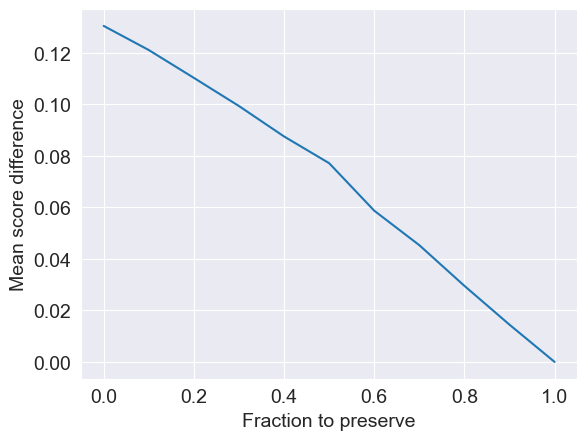

In [34]:
plt.plot(alphas, mean_differences)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")

Text(0, 0.5, 'Mean score percentage change')

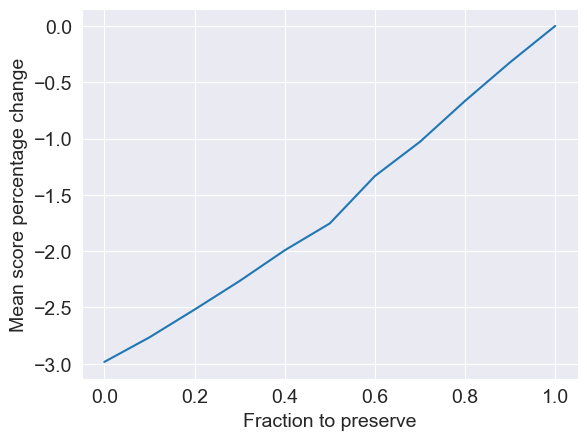

In [35]:
plt.plot(alphas, percentage_changes)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score percentage change")

# k2score boosting: shell_weight == Mid рекомендовано как градация, влияющая на ошибку больше всего
# k2score linear reg: height = High or height=Mid and Shell_weight=Low рекомендовано как градация, влияющая на ошибку больше всего

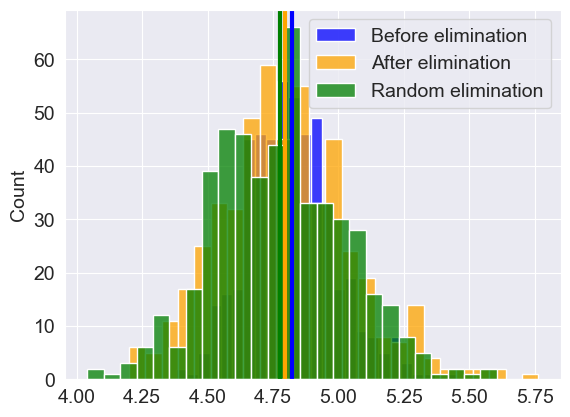

In [54]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.legend()

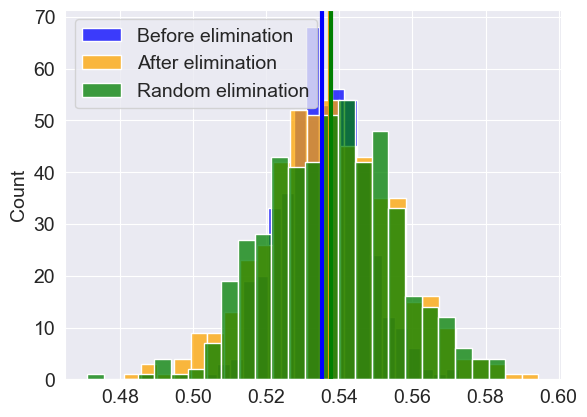

In [55]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.legend()

In [42]:
from scipy.stats import ttest_rel

In [57]:
ttest_rel(metrics_before[0], metrics_after[0])

TtestResult(statistic=2.8385109673024185, pvalue=0.004717184771158409, df=499)

In [58]:
ttest_rel(metrics_r[0], metrics_after[0])

TtestResult(statistic=-1.5935670712019205, pvalue=0.11166621879695462, df=499)

In [43]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,S_weight_0,S_weight_1,S_weight_2,W_weight_0,W_weight_1,W_weight_2,diameter_0,diameter_1,diameter_2,height_0,...,length_2,shell_weight_0,shell_weight_1,shell_weight_2,viscera_weight_0,viscera_weight_1,viscera_weight_2,ape_error_0,ape_error_1,ape_error_2
0,0,1,0,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
4171,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
4172,0,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
4173,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0


In [44]:
from itertools import product

In [45]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "ape_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "ape_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

2023-11-30 01:35:13,790 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,792 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,792 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,794 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,794 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,795 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,795 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,796 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,797 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2023-11-30 01:35:13,798 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [46]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,W_weight_0,Discrete,disc,[],[]
1,ape_error_1,Discrete,disc,[],[]
2,shell_weight_0,Discrete,disc,[W_weight_0],[disc]
3,S_weight_0,Discrete,disc,"[W_weight_0, shell_weight_0]","[disc, disc]"
4,diameter_0,Discrete,disc,"[S_weight_0, W_weight_0, shell_weight_0]","[disc, disc, disc]"
5,height_0,Discrete,disc,"[diameter_0, shell_weight_0]","[disc, disc]"
6,viscera_weight_0,Discrete,disc,"[diameter_0, height_0, shell_weight_0]","[disc, disc, disc]"
7,length_0,Discrete,disc,"[diameter_0, height_0, shell_weight_0, viscera...","[disc, disc, disc, disc]"
8,S_weight_2,Discrete,disc,"[length_0, shell_weight_0, viscera_weight_0]","[disc, disc, disc]"
9,diameter_2,Discrete,disc,"[S_weight_2, shell_weight_0, viscera_weight_0]","[disc, disc, disc]"


# k2score boosting: нет рекомендаций
# k2score boosting: height = High и Mid рекомендованы к удалению

In [54]:
np.random.seed(42)

#dfeat = ["length", "height"]
#dcat = [1, 2]
dfeat = ["diameter", "length", "viscera_weight"]
dcat = [1, 2, 2]

metrics_before, metrics_after, diffs, mean_dropped, metrics_r = bootstrap_sampling(dfeat, dcat, [mape, MSE, r2_score], trials=500,alpha=0.5, incl_random_removal=True)

100%|██████████| 500/500 [00:11<00:00, 44.16it/s]


In [55]:
mean_dropped, mean_dropped/n

(1672.788, 0.40047593966961936)

In [75]:
percentage_changes = list()
mean_differences = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    mses_before, mses_after, diffs, _ = bootstrap_sampling(dfeat, dcat, trials=500, alpha=a)
    if a == 0:
        print(_)
    x, y = np.array(mses_before), np.array(mses_after)
    mean_differences.append((x-y).mean())
    percentage_changes.append(((y-x)/x).mean()*100)
percentage_changes.append(0)
mean_differences.append(0)

TypeError: bootstrap_sampling() missing 1 required positional argument: 'metrics_list'

In [92]:
2280./n

0.5458463011730907

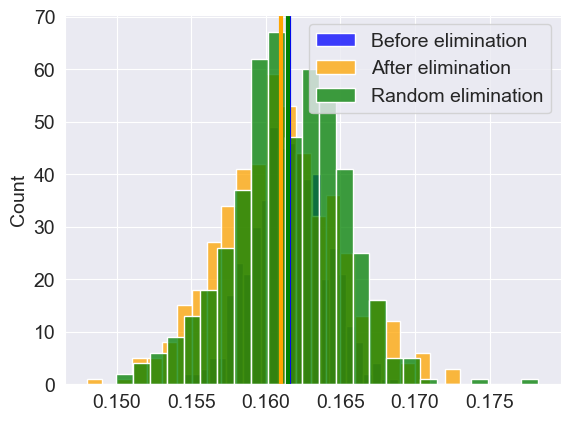

In [56]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.legend()

In [67]:
plt.plot(alphas, mean_differences)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")

NameError: name 'alphas' is not defined

Text(0, 0.5, 'Mean score percentage change')

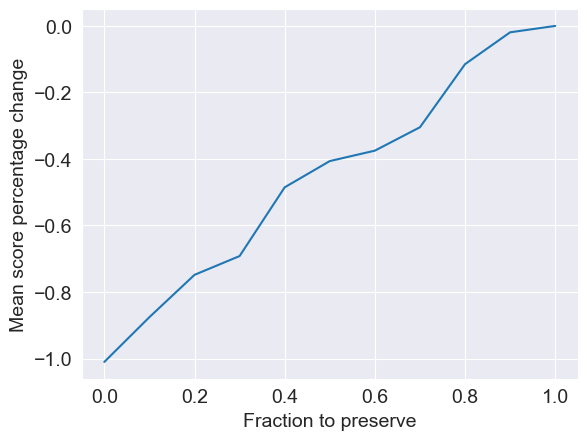

In [91]:
plt.plot(alphas, percentage_changes)
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score percentage change")

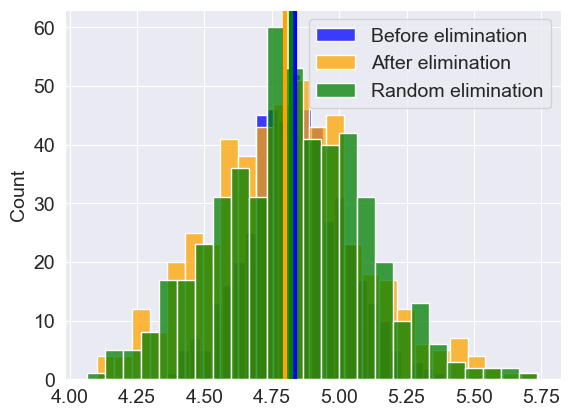

In [57]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.legend()

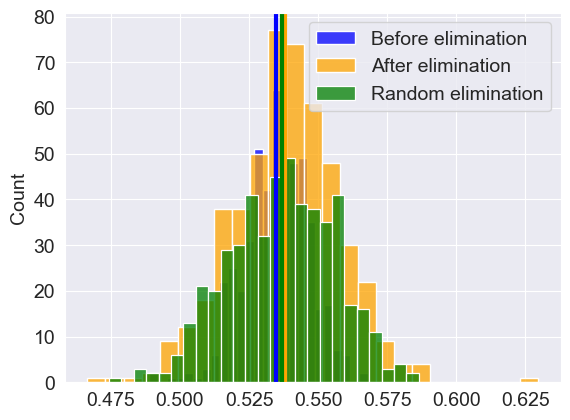

In [58]:
sns.histplot(metrics_before[2], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[2], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[2], label="Random elimination", bins=25, color="green")
plt.axvline(x=np.mean(metrics_before[2]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[2]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[2]), color="green", linewidth=3)
plt.legend()

In [134]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=2.9847571378258984, pvalue=0.002977257506233751, df=499)

In [42]:
disc_data_encoded = OneHotEncoder(sparse_output=False, dtype=np.int8).fit_transform(disc_data)
disc_data_encoded

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]], dtype=int8)

In [ ]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [ ]:
disc_data_onehot

In [ ]:
gbn = DiscreteBNGI(imagespath)

In [ ]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")